In [1]:
# This strategy assumes predictible returns based on last X number of bars and the relation between O,H,L,C.
# Motivation comes from YH's first book Algorithmic Trading

In [2]:
import datetime
import pandas as pd
import tstables  
import tables 
import numpy as np
import _create_research_data as bt_input
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
symbol = 'EUR_USD'
granularity = '1D'

filename = '{}_{}.hdf'.format(symbol, granularity)
df = bt_input.read_hdf_file(filename)
df = df[['bid_o', 'bid_h', 'bid_l', 'bid_c', 'volume']]
df.columns = ['open', 'high', 'low', 'close', 'volume']
df.head()

,open,high,low,close,volume
date,,,,,
2010-01-03,1.43070,1.43346,1.42909,1.43143,2809
2010-01-04,1.43140,1.44556,1.42569,1.44236,41638
2010-01-05,1.44234,1.44833,1.43464,1.43639,44858
2010-01-06,1.43642,1.44341,1.42824,1.44012,45640
2010-01-07,1.44010,1.44451,1.42992,1.43168,41808


In [4]:
df_reg = pd.DataFrame()
df_reg['returns'] = np.log(df['close'] / df['close'].shift(1))

df_reg.dropna(inplace=True)

lags = 5

cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    df_reg[col] = df_reg['returns'].shift(lag)
    cols.append(col)

df_reg.dropna(inplace=True)


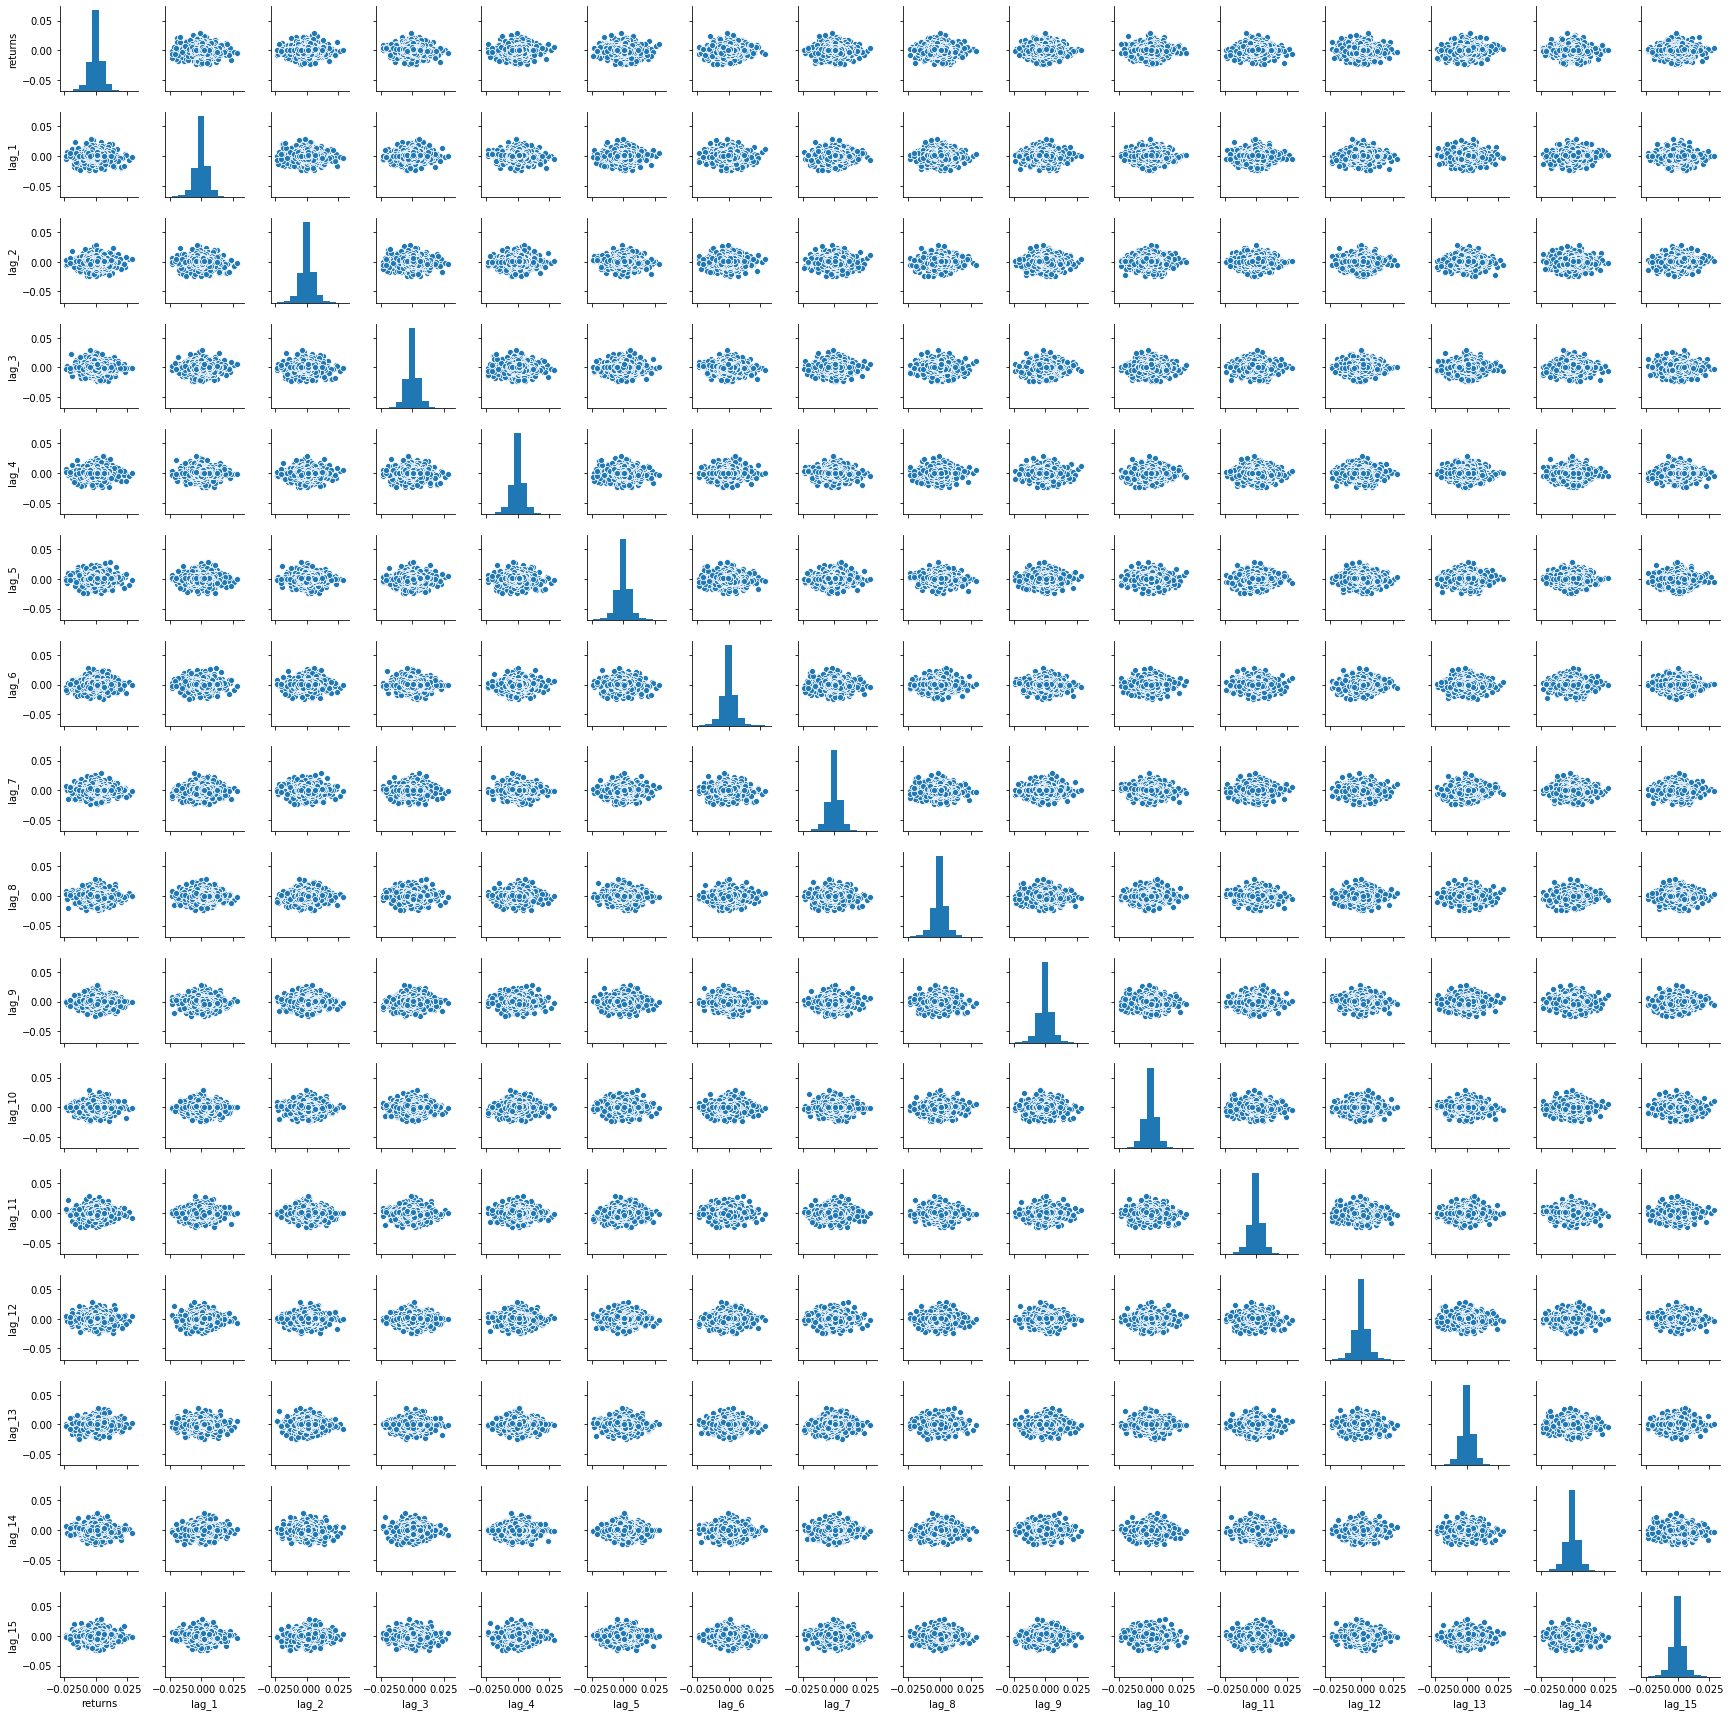

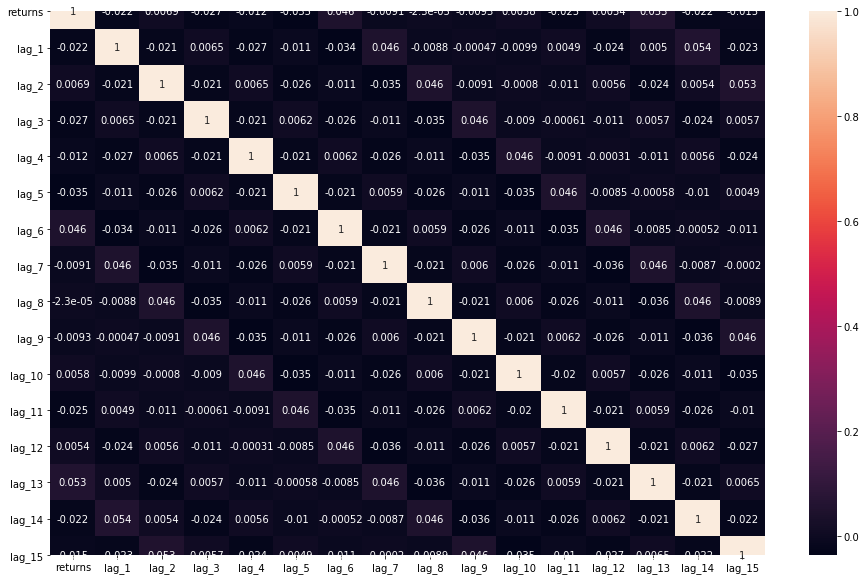

In [55]:
# Pairwise distribution
sns.pairplot(df_reg, height=1.5);
plt.show()

# Correlation
pd.options.display.float_format = '{:,.2f}'.format
df_reg.corr()

plt.figure(figsize=(16,10))
sns.heatmap(df_reg.corr(), annot=True)
plt.show()


In [35]:
df_reg.describe()

,returns,lag_1,lag_2,lag_3
count,"3,132.00","3,132.00","3,132.00","3,132.00"
mean,-0.00,-0.00,-0.00,-0.00
std,0.01,0.01,0.01,0.01
min,-0.02,-0.02,-0.02,-0.02
25%,-0.00,-0.00,-0.00,-0.00
50%,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00
max,0.03,0.03,0.03,0.03


Intercept: -7.861860089256648e-05    Coefficients: [-0.01953929  0.00731632 -0.02620706 -0.01490112 -0.03278905  0.04331419
 -0.01020467 -0.00085094 -0.00694769  0.00515736 -0.02249983  0.00217693
  0.05421435 -0.02213601 -0.01568644]


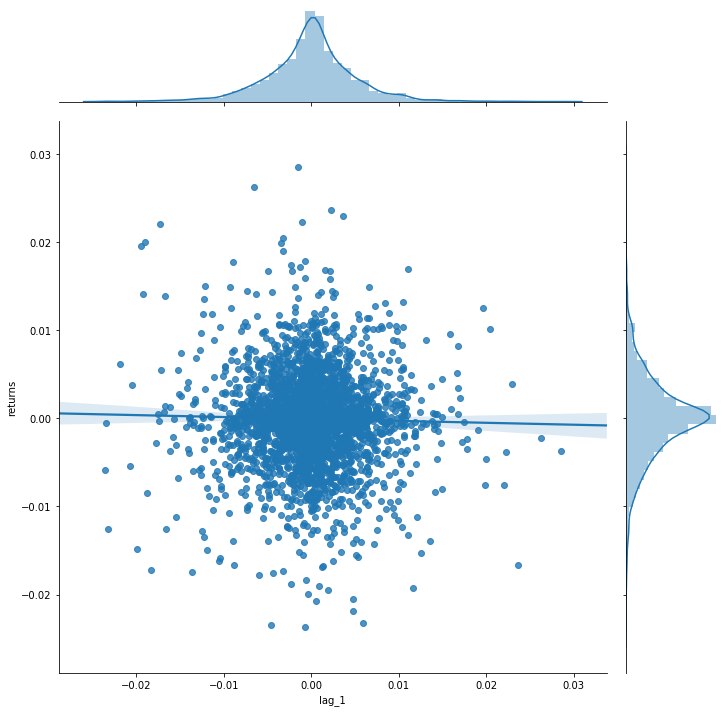

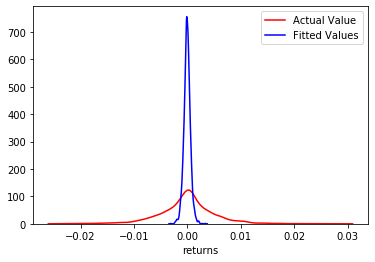

In [66]:
# Use ordinary least squares
X = df_reg[cols]
y = df_reg['returns']

# Ordinary Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
print( 'Intercept: {}    Coefficients: {}'.format(model.intercept_, model.coef_) )

df_reg['returns_pred'] = model.predict(X)

# Joint plot
sns.jointplot(x=X['lag_1'], y=y, kind='reg', height=10)
plt.show()

ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.show()

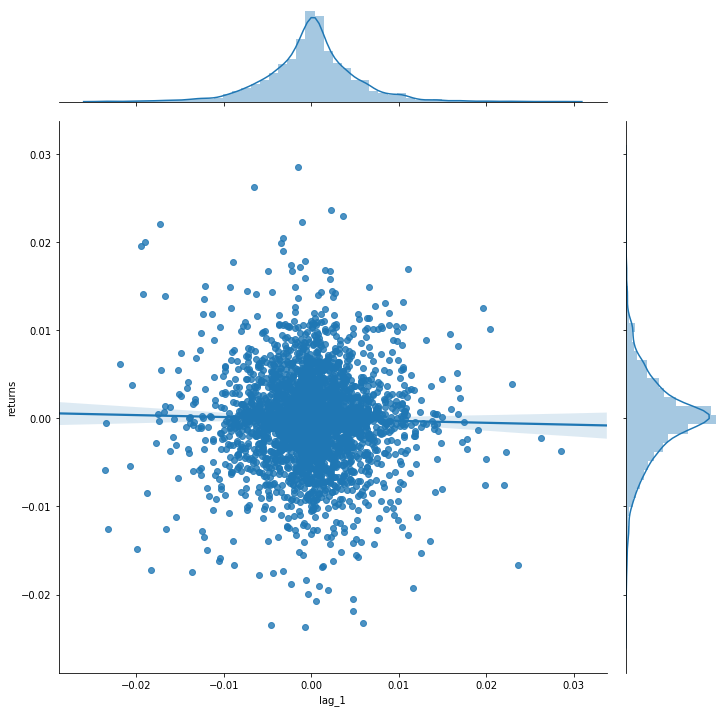

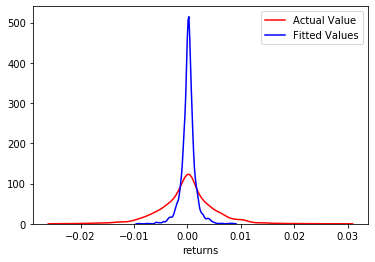

In [95]:
# Add polynomial terms 
# Use ordinary least squares

X = df_reg[cols]
y = df_reg['returns']

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
df_reg['returns_pred'] = lin_reg.predict(X_poly)

# Joint plot
sns.jointplot(x=X['lag_1'], y=y, kind='reg', height=10)
plt.show()

ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.show()

In [96]:
df_reg['sign_returns'] = np.sign(df_reg['returns'])
df_reg['sign_returns_pred'] = np.sign(df_reg['returns_pred'])
df_reg['hit'] = df_reg['sign_returns'] == df_reg['sign_returns_pred']
df_reg['hit'].value_counts()


True     3113
False       7
Name: hit, dtype: int64

In [115]:
X = df_reg[cols]
y = df_reg['returns']

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=6)
X_poly = poly_reg.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

temp_df = pd.DataFrame()
temp_df['y_test'] = y_test
temp_df['y_pred'] = y_pred
temp_df.to_excel('bbb6.xlsx')


In [110]:
hits = np.sign(y_pred * y_test)
print(hits.value_counts())

0.00     314
1.00     156
-1.00    154
Name: returns, dtype: int64


In [103]:
# Tried to use cross_validatio but stuck
# I somehow need to convert linear regression results to 0 and 1 and then use
# cross val but do not know how...

X = df_reg[cols]
y = df_reg['returns']

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X)

lin_reg = LinearRegression()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, X_poly, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


Accuracy: -0.11 (+/- 0.06)


In [212]:
X = df_reg[cols]
y = np.sign(df_reg['returns'])
y = np.where(y==0,-1,y)

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

from sklearn import linear_model

log_reg = linear_model.LogisticRegression(C=1e5, fit_intercept=True, solver='lbfgs', multi_class='auto', penalty='l2')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
prob = log_reg.predict_proba(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_pred, np.sign(y_test))

0.5303514376996805

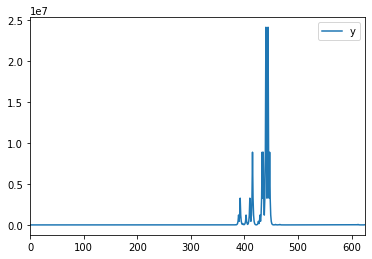

In [217]:
# Comparison did not work...
y_compare = pd.DataFrame()
y_compare['y'] = y_test
y_compare['y_pred'] = y_pred
y_compare['strategy'] = y_compare['y_pred'] * y_compare['y']

y_compare[['y']].cumsum().apply(np.exp).plot()

In [218]:
y_test

array([-1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
       -1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,
       -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,
       -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,
       -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1

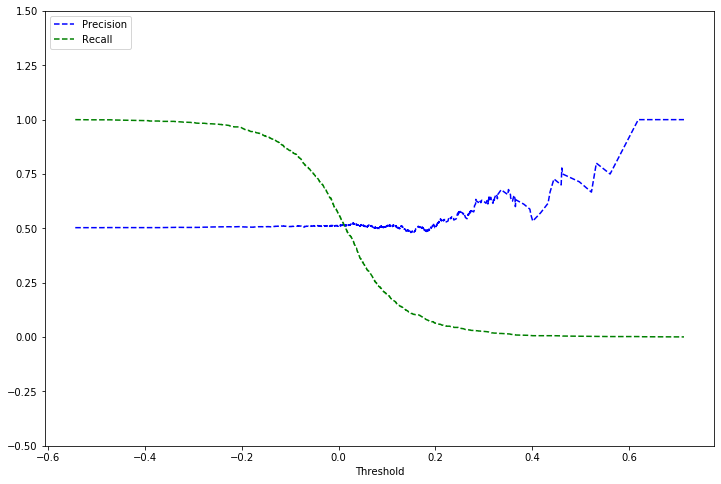

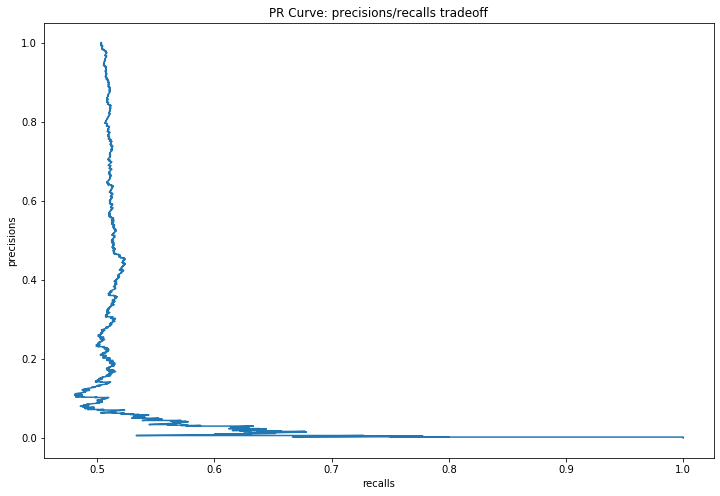

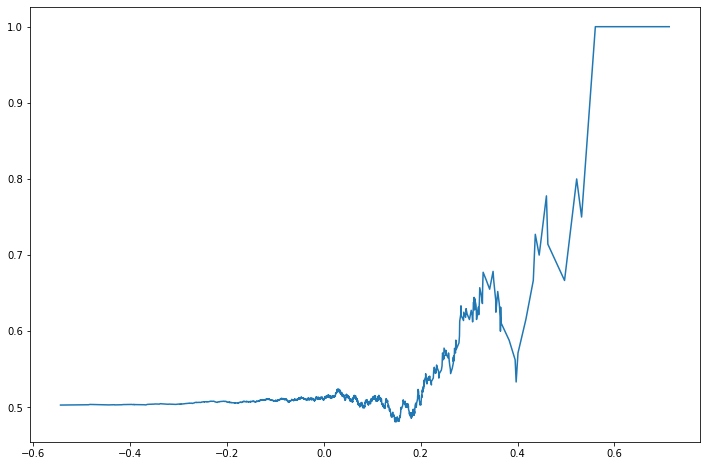

In [219]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(log_reg, X_train, y_train, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([-0.5,1.5])    
    
plt.figure(figsize=(12,8)); 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.figure(figsize=(12,8)); 
plt.plot(precisions, recalls);
plt.xlabel('recalls');
plt.ylabel('precisions');
plt.title('PR Curve: precisions/recalls tradeoff');

plt.figure(figsize=(12,8)); 
plt.plot(thresholds, precisions[1:]);
plt.show()    


In [33]:
#X = df_reg[cols]
#y = np.sign(df_reg['returns'])
X = np.where(df_reg[cols] > 0, 1, 0)
y = np.where(df_reg['returns'] > 0, 1, 0)

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=1)
X_poly = poly_reg.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

from sklearn.neural_network import MLPClassifier
ml_model = MLPClassifier(hidden_layer_sizes=[32], max_iter=1000)
ml_model.fit(X_train, y_train)

y_pred = ml_model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_pred, np.sign(y_test))

0.5351437699680511

In [35]:
import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
tf.random.set_seed(500)
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags+1,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, verbose=False)


In [36]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>=.5, 1, 0)

from sklearn.metrics import accuracy_score
accuracy_score(y_pred, np.sign(y_test))

0.5543130990415336

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
    